In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import inspect

currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
srcdir = parentdir + '/src'
os.sys.path.insert(1, srcdir)

import numpy as np

import time
import pybullet as p
import pybullet_data
import pinocchio as se3
import matplotlib
import tsid
import numpy.matlib as matlib
from numpy import nan
from numpy.linalg import norm as norm
import commands

import matplotlib.pyplot as plt
from pinbullet_wrapper import PinBulletWrapper
from pinocchio.robot_wrapper import RobotWrapper
from pinocchio.utils import zero
from romeo_foot import RomeoFoot

from dotmap import DotMap
import pickle

In [2]:
font = {'family' : 'serif',
        'size'   : 22}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3, linewidth=200, suppress=True)

In [3]:
LOGGING = False
STEP_DURATION = 800
N_STEPS = 9
N_SIMULATION = N_STEPS * STEP_DURATION
DELAY = 25
DELAY_START = 0
IMPACT_START = 2400
IMPACT_DURATION = 200
IMPACT_FORCE = [100, 0, 0]
LOCAL = True
BMODE = p.GUI
NODELAY_WINDOW = 50
DOUBLE_SUPPORT_DURATION = 5

NS3 = True
SCENARIO = 'building'

In [4]:
# compute delayed indices
DELAYED_IDX = []
landing = STEP_DURATION
steps_taken = 0

if NS3:
    td = np.load('td_'+ SCENARIO +'.npy')
    td = np.tile(td, int((N_SIMULATION + 1.0)/len(td)) + 1)
    td = td[:N_SIMULATION]
    time_received = np.array([i + td[i] - 1 for i in range(N_SIMULATION)])
    
    for i in range(N_SIMULATION):
        # find the latest command arrived before the current time
        idx_arrived = np.nonzero(time_received <= i)[0]
        if idx_arrived.size > 0:
            delayed_idx = idx_arrived.max()
        else:
            delayed_idx = 0
            
        DELAYED_IDX.append(delayed_idx)
    
    
else:
    for i in range(N_SIMULATION):
        if i >= DELAY_START:
            delayed_idx = np.maximum(i-DELAY, DELAY_START)
        else:
            delayed_idx = i
        DELAYED_IDX.append(delayed_idx)

In [5]:
# ad-hoc processing to make sure no delays when making contact

for i in range(N_SIMULATION):
    for steps in range(1, N_STEPS):
        landing = STEP_DURATION * steps
        if landing - NODELAY_WINDOW <= i < landing + NODELAY_WINDOW:
            DELAYED_IDX[i] = i
            
for i in range(N_SIMULATION):
    for steps in range(1, N_STEPS):
        landing = STEP_DURATION * steps
        if landing - NODELAY_WINDOW <= DELAYED_IDX[i] < landing + NODELAY_WINDOW:
            if landing - NODELAY_WINDOW <= i < landing + NODELAY_WINDOW:
                DELAYED_IDX[i] = i
            else:
                DELAYED_IDX[i] = landing + NODELAY_WINDOW - 1

In [6]:
Com = np.load(parentdir+'/data/com.npy')
foot_steps = np.load(parentdir+'/data/foot_steps.npy')
left_foot_steps = foot_steps[1::2]
right_foot_steps = foot_steps[0::2]

In [7]:
mu = 0.3                            # friction coefficient
rf_frame_name = "RAnkleRoll"        # right foot frame name
lf_frame_name = "LAnkleRoll"        # left foot frame name

w_com = 1.0                     # weight of center of mass task
w_posture = 1e-3                # weight of joint posture task
w_forceRef = 1e-5               # weight of force regularization task
w_foot_motion = 1.0

kp_contact = 10.0               # proportional gain of contact constraint
kd_contact = 7.0
kp_com = 10.0                   # proportional gain of center of mass task
kp_posture = 50.0               # proportional gain of joint posture task
kp_foot_motion = 30.0
kd_foot_motion = 1000.0

In [8]:
path = parentdir + '/models/romeo'
robot_urdf = path + '/urdf/romeo.urdf'
plane_urdf = parentdir + '/models/plane.urdf'
vector = se3.StdVec_StdString()
vector.extend(item for item in path)
robot = tsid.RobotWrapper(robot_urdf, vector, se3.JointModelFreeFlyer(), False)
pinocchio_robot = se3.buildModelFromUrdf(robot_urdf, se3.JointModelFreeFlyer())

In [9]:
physicsClient = p.connect(BMODE)#or p.DIRECT for non-graphical version
dt = 1./1000.
p.setTimeStep(dt)
p.setGravity(0,0,-9.81)
robot_id = p.loadURDF(robot_urdf,[0,0,0])
plane_id = p.loadURDF(plane_urdf,[0,0,-0.88], useFixedBase=1)

In [10]:
joint_names = [n for n in robot.model().names]
del joint_names[0]
del joint_names[0]
endeff_names = ["l_sole", "r_sole"]
pbwrapper = PinBulletWrapper(robot_id, pinocchio_robot, joint_names, endeff_names)

In [11]:
p.changeDynamics(plane_id, -1, restitution=0.99,
                 lateralFriction=1.0, spinningFriction=1.0, rollingFriction=1.0,
                 contactStiffness=1e6, contactDamping=2e3)
p.resetJointState(robot_id, 20, np.pi/2)
p.resetJointState(robot_id, 27, np.pi/2)

In [12]:
q, v = pbwrapper.get_state()
assert robot.model().existFrame(rf_frame_name)
assert robot.model().existFrame(lf_frame_name)

In [13]:
t = 0.

invdyn = tsid.InverseDynamicsFormulationAccForce("tsid", robot, False)
invdyn.computeProblemData(t, q, v)
data = invdyn.data()

comTask = tsid.TaskComEquality("task-com", robot)
comTask.setKp(kp_com * np.matrix(np.ones(3)).transpose())
comTask.setKd(2.0 * np.sqrt(kp_com) * np.matrix(np.ones(3)).transpose())
invdyn.addMotionTask(comTask, w_com, 1, 0.0)

postureTask = tsid.TaskJointPosture("task-posture", robot)
postureTask.setKp(kp_posture * np.matrix(np.ones(robot.nv-6)).transpose())
postureTask.setKd(2.0 * np.sqrt(kp_posture) * np.matrix(np.ones(robot.nv-6)).transpose())
invdyn.addMotionTask(postureTask, w_posture, 1, 0.0)

com_ref = Com[0,0].reshape((-1,1))
trajCom = tsid.TrajectoryEuclidianConstant("traj_com", com_ref)

q_ref = q[7:].copy()
q_ref[3] = np.pi/4
q_ref[9] = np.pi/4
q_ref[2] = -np.pi/6
q_ref[8] = -np.pi/6

trajPosture = tsid.TrajectoryEuclidianConstant("traj_joint", q_ref)

solver = tsid.SolverHQuadProgFast("qp solver")
solver.resize(invdyn.nVar, invdyn.nEq, invdyn.nIn)

In [14]:
left_foot = RomeoFoot(lf_frame_name, invdyn, robot)
right_foot = RomeoFoot(rf_frame_name, invdyn, robot)

left_foot.add_contact_task(kp=kp_contact, kd=kd_contact, w_forceRef=w_forceRef, mu=mu)
right_foot.add_contact_task(kp=kp_contact, kd=kd_contact, w_forceRef=w_forceRef, mu=mu)

left_foot.add_foot_steps(left_foot_steps)
right_foot.add_foot_steps(right_foot_steps)

In [15]:
## move to the initial configuration
for i in range(2000):
    
    sampleCom = trajCom.computeNext()
    comTask.setReference(sampleCom)
    samplePosture = trajPosture.computeNext()
    postureTask.setReference(samplePosture)
    HQPData = invdyn.computeProblemData(t, q, v)
    
    sol = solver.solve(HQPData)
    tau = invdyn.getActuatorForces(sol)
              
    # bullet
    pbwrapper.send_joint_command(tau)    
    p.stepSimulation()
    q, v = pbwrapper.get_state()
    t += dt
    
Com[:,0,2] = robot.com(invdyn.data())[2, 0]

In [16]:
left_foot.add_motion_task(kp=kp_foot_motion, kd=kd_foot_motion, w=w_foot_motion)
right_foot.add_motion_task(kp=kp_foot_motion, kd=kd_foot_motion, w=w_foot_motion)

In [17]:
feet = [left_foot, right_foot]
left_foot.lift()
left_foot.take_the_next_step()
right_foot.take_the_next_step()

swing_foot_idx = 0
support_foot_idx = 1

landing = STEP_DURATION

In [18]:
LOG = []
SOL = []

for i in range(N_SIMULATION):
    
    data = DotMap()
    LOG.append(data)
    
    swing_foot = feet[swing_foot_idx]
    support_foot = feet[support_foot_idx]
            
    if i > 0 and i % STEP_DURATION == 0:
        swing_foot.land()
        
    if i == landing + DOUBLE_SUPPORT_DURATION:
        landing += STEP_DURATION
        support_foot.lift()
        support_foot.take_the_next_step()
        swing_foot_idx, support_foot_idx = support_foot_idx, swing_foot_idx
        
    right_foot.update(dt)
    left_foot.update(dt)
        
    sampleCom = trajCom.computeNext()
    sampleCom.pos(Com[i,0].reshape(-1, 1))
    sampleCom.vel(Com[i,1].reshape(-1, 1))
    sampleCom.acc(Com[i,2].reshape(-1, 1))
    samplePosture = trajPosture.computeNext()
    postureTask.setReference(samplePosture)
    comTask.setReference(sampleCom)
    
    noise_q = 0 * np.matrix(np.random.randn(q.shape[0])).T
    noise_q[:7] = 0
    noise_v = 0 * np.matrix(np.random.randn(v.shape[0])).T
    noise_v[:6] = 0
    
    HQPData = invdyn.computeProblemData(t, q + noise_q, v + noise_v)
    data.q = q + noise_q
    data.v = v + noise_v
    data.noise_q = noise_q
    data.noise_v = noise_v
    
    sol_remote = solver.solve(HQPData)
    if(sol.status!=0):
        print "QP problem could not be solved! Error code:", sol.status
        break
        
    SOL.append(sol_remote)
    tau = invdyn.getActuatorForces(sol_remote)
    dv = invdyn.getAccelerations(sol_remote)
    data.tau_remote = tau
    data.dv_remote = dv
    data.activeset_remote = sol.activeSet
    
    delayed_idx = DELAYED_IDX[i]
    data.delay = i - delayed_idx
    delayed_data = LOG[delayed_idx]
    delayed_sol = SOL[delayed_idx]
    
    if LOCAL:
        HQPData = invdyn.computeProblemData(t, q + noise_q, v + noise_v)
        sol = solver.solve_local(HQPData, delayed_sol)
        tau = invdyn.getActuatorForces(sol)
        dv = invdyn.getAccelerations(sol)
    else: 
        solver.compute_slack(HQPData, delayed_sol)
        sol = delayed_sol
        tau = delayed_data.tau_remote
        dv = delayed_data.dv_remote
        
    data.slack = sol.slack
    data.tau = tau
    data.dv = dv
    data.activeset = sol.activeSet
    
    # data logging from noiseless measurements
    HQPData = invdyn.computeProblemData(t, q, v)
    data.com.pos = robot.com(invdyn.data())
    data.com.pos_ref = sampleCom.pos()
    data.left_foot.pos = left_foot.pos(t,q,v).translation
    data.left_foot.pos_ref = left_foot.motion_ref.pos()[:3]
    data.right_foot.pos = right_foot.pos(t,q,v).translation
    data.right_foot.pos_ref = right_foot.motion_ref.pos()[:3]

#     # bullet
#     pbwrapper.send_joint_command(tau)
# #     if IMPACT_START <= i <= IMPACT_START + IMPACT_DURATION:
# #         p.applyExternalForce(robot_id, 0, IMPACT_FORCE, [0,0,0], p.LINK_FRAME)
#     p.stepSimulation()
#     q, v = pbwrapper.get_state()
#     t += dt
    
    # pinocchip
    v_mean = v + 0.5*dt*dv
    v += dt*dv
    q = se3.integrate(robot.model(), q, dt*v_mean)
    pbwrapper.reset_state(q, v)
    p.stepSimulation()
    t += dt

In [19]:
p.disconnect()

In [20]:
exp_data = DotMap()
file_name = 'walk_'
data_path = parentdir + '/data/'

if NS3:
    exp_data.scenario = SCENARIO
    file_name += SCENARIO
    data_path += 'ns3/'
else:
    exp_data.delay = DELAY
    exp_data.delay_start = DELAY_START
    file_name += str(DELAY)
    data_path += 'const/'
    
exp_data.local = LOCAL
if LOCAL:
    file_name += '_local'
exp_data.impact_start = IMPACT_START
exp_data.impact_duration = IMPACT_DURATION
exp_data.impact_force = IMPACT_FORCE
exp_data.log = LOG

In [21]:
if LOGGING:
    with open(data_path + file_name + '.pkl', 'wb') as f:
        pickle.dump(exp_data, f, pickle.HIGHEST_PROTOCOL)

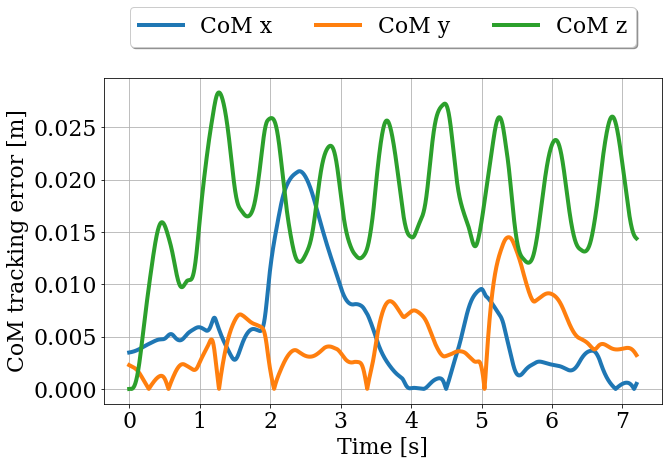

In [22]:
fig, ax = plt.subplots(1, figsize=(10, 6))
time = np.arange(0.0, N_SIMULATION*dt, dt)
axes = ['x', 'y', 'z']
for i in range(3):
    err = np.abs([data.com.pos[i,0]-data.com.pos_ref[i,0] for data in LOG])
    ax.plot(time, err, lw=4, label='CoM '+axes[i])
    
ax.grid()
ax.set_xlabel('Time [s]')
ax.set_ylabel('CoM tracking error' + ' [m]' )
# ax.set_ylim([0, 30])

_ = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
             ncol=3, fancybox=True, shadow=True)

0.18083923290653925


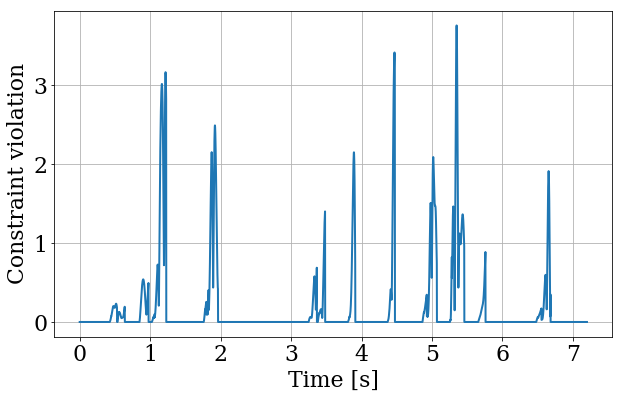

In [23]:
fig, ax = plt.subplots(1, figsize=(10, 6))
time = np.arange(0.0, N_SIMULATION*dt, dt)
axes = ['x', 'y', 'z']
slack = [data.slack[1, 0] for data in LOG]
ax.plot(time, slack, lw=2)
ax.grid()
ax.set_xlabel('Time [s]')
ax.set_ylabel('Constraint violation' )
slack = np.array(slack)
slack = slack[slack<1000]
print slack.mean()

13.423758099127328


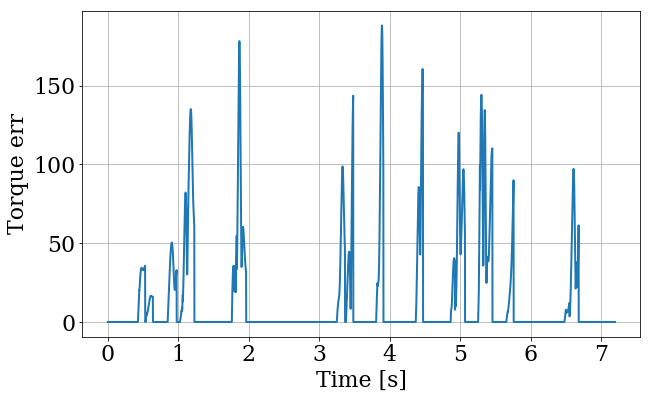

In [24]:
fig, ax = plt.subplots(1, figsize=(10, 6))
time = np.arange(0.0, N_SIMULATION*dt, dt)
axes = ['x', 'y', 'z']
err = [np.linalg.norm(data.tau[:,0]-data.tau_remote[:,0]) for data in LOG]
ax.plot(time, err, lw=2)
ax.grid()
ax.set_xlabel('Time [s]')
ax.set_ylabel('Torque err' )

print np.mean(err)

Text(0,0.5,'Delay [ms]')

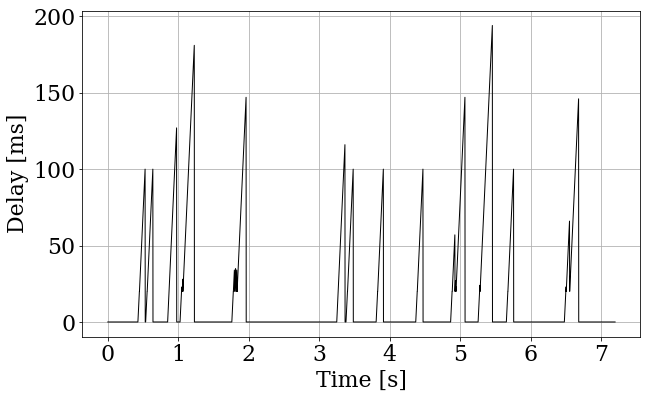

In [25]:
fig, ax = plt.subplots(1, figsize=(10, 6))
time = np.arange(0.0, N_SIMULATION*dt, dt)
axes = ['x', 'y', 'z']
delays = [data.delay for data in LOG]
ax.plot(time, delays, lw=1, color='k')
ax.grid()
ax.set_xlabel('Time [s]')
ax.set_ylabel('Delay [ms]' )
